# Read this section importantly!

In [ ]:
!nvidia-smi

Fri Apr 28 04:19:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 22.5 MB/s eta 0:00:00


In [ ]:
pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.5 MB/s eta 0:00:00


In [ ]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torchvision.transforms as tvt
import torchaudio.transforms as tat
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import gc

import zipfile
import pandas as pd
from tqdm import tqdm
import os
import datetime

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

Device:  cuda
Device:  cuda


# Dataset and Dataloaders

In terms of the dataset, the dataset structure for HW3P2 and HW4P2 dataset are very similar. Can you spot out the differences? What all will be required?? 

Hints:

- Check how big is the dataset (do you require memory efficient loading techniques??)
- How do we load mfccs? Do we need to normalise them? 
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Would we want a collating function? Ask yourself: Why did we need a collate function last time?
- Observe the VOCAB, is the dataset same as HW3P2? 
- Should you add augmentations, if yes which augmentations? When should you add augmentations? (Check bootcamp for answer)


In [ ]:
def technical_indicators(df):
  df_close=df['Close']
  df_close=pd.DataFrame(df_close, columns=['Close'])
  df11=df_close.reset_index()
  #RSI
  df11['change'] = df11['Close'].diff()
  df['change']=df11['change']
  df['delta']=(df['change']>0)*1.
  def rma(x, n):
      """Running moving average"""
      a = np.full_like(x, np.nan)
      a[n] = x[1:n+1].mean()
      for i in range(n+1, len(x)):
          a[i] = (a[i-1] * (n - 1) + x[i]) / n
      return a

  #SMA  #10days
  df11['SMA10'] = df11['Close'].rolling(10).mean()

  df11.drop(columns=['Close','change','index'], inplace=True)
  df_cat=pd.concat([df, df11], axis=1)
  df_cat.fillna(method='bfill', axis=0, inplace=True)
  df_cat.fillna(method='ffill', axis=0, inplace=True)
  return df_cat
APPL_price = pd.read_csv("AAPL.csv")
APPL=technical_indicators(APPL_price).drop(columns=['Date','Adj Close'])
print(APPL.columns)
# APPL=APPL.reset_index()
APPL

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'change', 'delta', 'SMA10'], dtype='object')


,Open,High,Low,Close,Volume,change,delta,SMA10
0,44.122501,44.735001,44.102501,44.560001,106421600,-0.100002,0.0,41.955750
1,44.452499,44.705002,44.220001,44.459999,83018000,-0.100002,0.0,41.955750
2,43.439999,43.847500,43.165001,43.200001,139235200,-1.259998,0.0,41.955750
3,42.650002,42.805000,41.357498,41.430000,261964400,-1.770001,0.0,41.955750
4,41.707500,41.730000,41.022499,41.310001,146062000,-0.119999,0.0,41.955750
...,...,...,...,...,...,...,...,...
1253,161.419998,162.029999,160.080002,162.029999,47716900,-2.630005,0.0,162.620999
1254,162.350006,162.360001,160.509995,160.800003,47644200,-1.229996,0.0,162.873000
1255,161.220001,162.059998,159.779999,160.100006,50133100,-0.699997,0.0,163.118001
1256,161.630005,165.800003,161.419998,165.559998,68445600,5.459992,1.0,163.597000


In [ ]:
#Normalize time series
Scaler = StandardScaler()
dataset_standard = Scaler.fit_transform(APPL)
dataset=dataset_standard
dataset_standard

array([[-1.31183863, -1.30951346, -1.30229994, ..., -0.08578765,
        -1.06575017, -1.35283032],
       [-1.30461523, -1.3101618 , -1.29969553, ..., -0.08578765,
        -1.06575017, -1.35283032],
       [-1.32677808, -1.32869415, -1.3230798 , ..., -0.5939528 ,
        -1.06575017, -1.35283032],
       ...,
       [ 1.25133667,  1.22611664,  1.26171308, ..., -0.34863041,
        -1.06575017,  1.30123432],
       [ 1.26031134,  1.3069457 ,  1.29806396, ...,  2.34990628,
         0.93830621,  1.31172683],
       [ 1.3251033 ,  1.31818403,  1.3512606 , ..., -0.19530156,
        -1.06575017,  1.31796978]])

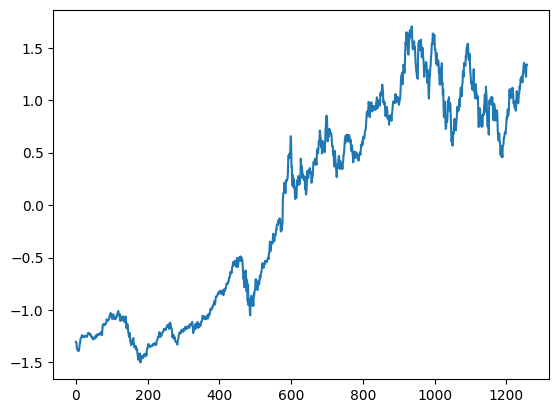

In [ ]:
plt.plot(dataset_standard[:,3]) #plot closing price

In [ ]:
# dataset=np.array(APPL)
dataset=dataset.tolist()*1  #TODO: try to Tune, to repeat stock price make longer dataset
len(dataset)
a=int(0.55*len(dataset))
X_train=dataset[0:a]
X_test=dataset[a:]
print(len(X_train))
len(X_test)


691


567

In [ ]:
# data=dataset[]

In [ ]:
#TODO: try to tune this
config = {
  'batch_size': 64,
  'lr':1e-4,
  'epochs': 30,
}

In [ ]:
class TransformerDataset(Dataset):
    def __init__(self, data, indices, enc_seq_len, pred_seq_len) :
        super().__init__()
        self.data = data
        self.indices = indices
        self.enc_seq_len = enc_seq_len
        self.pred_seq_len = pred_seq_len

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        start, end = self.indices[index]

        sequence = self.data[start:end]

        src = sequence[:self.enc_seq_len]      #0~59 inclusive
        tgt = sequence[self.enc_seq_len-self.pred_seq_len+1 : self.enc_seq_len+1]     #56~60 inclusive
        true = sequence[self.enc_seq_len+1:]     #61~65 inclusive

        return src, tgt, true
    

In [ ]:
def get_windows(data, window_size, step_size):
    start = 0
    end = window_size
    
    indices = []
    while end < len(data):      #proceed window by step size, count how many sequences 
        indices.append( (start, end) )
        start += step_size
        end += step_size
    return indices

In [ ]:
# plt.plot(np.array(X_train)[:,4])

torch.Size([128, 30, 8]) torch.Size([128, 7, 8])
x:  tensor([-1.3528, -1.3578, -1.3585, -1.3563, -1.3464, -1.3355, -1.3228, -1.3098,
        -1.2957, -1.2813, -1.2688, -1.2593, -1.2529, -1.2474, -1.2460, -1.2447,
        -1.2441, -1.2435, -1.2445, -1.2446, -1.2447, -1.2441, -1.2448, -1.2430,
        -1.2400, -1.2369, -1.2332, -1.2304, -1.2284, -1.2270])
tgt:  tensor([-1.2400, -1.2369, -1.2332, -1.2304, -1.2284, -1.2270, -1.2246])
y_train:  tensor([-1.2228, -1.2207, -1.2215, -1.2231, -1.2273, -1.2314, -1.2358])


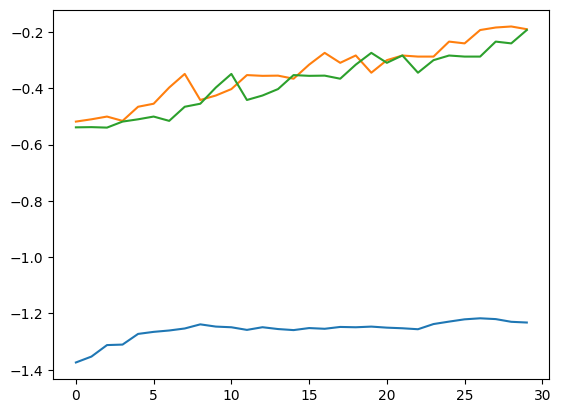

In [ ]:
# Dataset Dataloader:
#TODO: tune context_len and pred_len
context_len=30
pred_len=7
window_size=context_len+pred_len+1
training_indices = get_windows(X_train, window_size, step_size=3) #TODO: Tune step size... 
val_indices = get_windows(X_test, window_size, step_size=1) #TODO: Tune step size... 
test_indices = get_windows(dataset, window_size, step_size=1) 

# print(training_indices)
train_data=TransformerDataset(torch.FloatTensor(X_train), training_indices, context_len, pred_len) 
val_data=TransformerDataset(torch.FloatTensor(X_test), val_indices, context_len, pred_len) 
test_data=TransformerDataset(torch.FloatTensor(dataset), test_indices, context_len, pred_len) 

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data, 
    batch_size  = 128,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data, 
    batch_size  = 24,
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data, 
    batch_size  = 1,
    pin_memory  = False
)

for batch in train_loader: 
    src, tgt, y_train=batch
    print(src.shape, tgt.shape)
    print("x: ", src[0,:,-1])   #60 days context  
    print("tgt: ", tgt[0,:,-1]) #should be next five days 
    print("y_train: ", y_train[0,:,-1])  #True label should shift by one to right
    plt.plot(src[0,:,3])
    plt.plot(src[1,:,3])
    plt.plot(src[2,:,3]) #
    break

In [ ]:
class PositionalEncoder(nn.Module):
    def __init__(self,  max_seq_len = 5000, d_model = 512, dropout= 0.1,):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        time = torch.arange(0, max_seq_len).unsqueeze(1)
        self.positional_encoding = torch.zeros(1,max_seq_len, d_model).to(DEVICE)
        xx= (torch.arange(0,max_seq_len).reshape(-1, 1).to(DEVICE)) / torch.pow(10000, torch.arange(0, d_model, 2)/d_model).to(DEVICE)
        self.positional_encoding[:, :, 0::2] = torch.sin(xx)
        self.positional_encoding[:, :, 1::2] = torch.cos(xx)

        self.register_buffer('pe', self.positional_encoding)

    def forward(self, x) :
        x = x + self.positional_encoding[:,:x.shape[1]]
        x=self.dropout(x)
        return x


In [ ]:
class Transformer(nn.Module):
    def __init__(self, input_dim=8, output_dim=1, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,encode_seq_len=60,pred_seq_len=10):
        super(Transformer, self).__init__()
        self.nhead=nhead
        self.d_model=d_model
        self.encode_seq_len=encode_seq_len
        self.embedding = nn.Linear(input_dim, d_model) 
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.pred_seq_len=pred_seq_len
        self.linear_out = nn.Linear(d_model, 1)
        self.positional_encoding_layer = PositionalEncoder(encode_seq_len, d_model, dropout  )

    def forward(self, x, query, src_mask=None, tgt_mask=None):
        # print("in,",x.shape) #32 10 29, batch len feature
        batch_size, seq_len, feature=x.shape

        # #encode x
        x = self.embedding(x) 
        x = self.positional_encoding_layer(x)

        #encode query
        query=self.embedding(query) 

        encoder_out = self.encoder(x)
        decoder_out = self.decoder(query, encoder_out,tgt_mask=tgt_mask, memory_mask=src_mask )
        # print("asdasdasdasdasd",decoder_out.shape)

        # attn_weights = self.decoder.layers[-1].multihead_attn.attn_output_weights

        decoder_out = self.linear_out(decoder_out)
        
        return decoder_out


In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#TODO: tune model parameters
model=Transformer(input_dim=8, output_dim=1, d_model=512, nhead=4, 
                  num_encoder_layers=4, num_decoder_layers=4, dim_feedforward=256, 
                  dropout=0.3, encode_seq_len=context_len, pred_seq_len=pred_len).to(device)
# print(x.size)
for x, y,z in train_loader: 
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    out=model(x,y)
    print("x shape:", x.shape, "y shape:", y.shape)
    print("out shape:", out.shape)
    # summary(model, x1)
    break
print("context len:",model.encode_seq_len,"pred_len:", model.pred_seq_len)

x shape: torch.Size([128, 30, 8]) y shape: torch.Size([128, 7, 8])
out shape: torch.Size([128, 7, 1])
context len: 30 pred_len: 7


# Model Setup 

# Loss Function, Optimizers, Scheduler

In [ ]:
optimizer   = torch.optim.Adam(model.parameters(), lr= config['lr'])
criterion   = torch.nn.SmoothL1Loss() 
scaler      = torch.cuda.amp.GradScaler()

# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

# Train and Validation functions 


In [ ]:
class Trainer():
  def __init__(self, model, loader, optimizer, criterion, scheduler, val_loader):
    self.model      = model
    self.loader     = loader
    self.optimizer  = optimizer
    self.criterion  = criterion
    self.train_plot=[]
    self.teacher=True
    self.val_loader=val_loader
    
  def train(self, teacher_forcing_rate):
      self.model.train() # set to training mode
      self.model.to(device)

      batch_bar = tqdm(total=len(self.loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(self.loader):
          self.optimizer.zero_grad()

          src, trg, y_train = batch

          src = src.to(device)
          trg = trg.to(device)
          y_train = y_train.to(device)

          batch_size = src.shape[0]


          y_pred = self.model(src, trg, src_mask=None, tgt_mask=None).reshape(-1,1)

          #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
          pred_what=3
          loss = criterion(y_pred, y_train[:,:,pred_what].reshape(-1,1))    #TODO: try changing 8 to others, if want the model to learn other columns
          
          loss.backward()
          torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1e+6)
          optimizer.step()
          
          self.train_plot.append(loss.item())
          running_loss += loss.item()
          
          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(self.optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del src, trg, y_train
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(self.loader)

  def validate(self):
      self.model.eval() # set to training mode
      self.model.to(device)

      batch_bar = tqdm(total=len(self.loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(self.val_loader):
          self.optimizer.zero_grad()

          src, trg, y_test = batch

          src = src.to(device)
          trg = trg.to(device)
          y_test = y_test.to(device)

          batch_size = src.shape[0]

          y_pred = self.model(src, trg, src_mask=None, tgt_mask=None).reshape(-1,1)

          #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
          pred_what=3
          # print(y_pred[:,1].shape,y_test[:,1,pred_what].shape)
          val_loss = criterion(y_pred[:,0], y_test[:,0,pred_what].reshape(-1,1))    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()
          
          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del src, trg, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(self.loader)

  def test(self, test_loader):
        self.model.eval() # set to training mode
        self.model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        for i, batch in enumerate(test_loader):
            self.optimizer.zero_grad()

            src, trg, y_test = batch

            src = src.to(device)
            trg = trg.to(device)

            batch_size = src.shape[0]


            y_pred = self.model(src, trg, src_mask=None, tgt_mask=None)[:,0]
            prediction.append(y_pred[0])

            #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
            del src, trg, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()

        return prediction

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.995)
trainer=Trainer(model, train_loader, optimizer, criterion,  scheduler, val_loader=val_loader)


Epoch: 1/200


	Train Loss 1.1165	 Learning Rate 0.0001000	 Validation Loss 2.8923

Epoch: 2/200


	Train Loss 0.5538	 Learning Rate 0.0000995	 Validation Loss 10.0475

Epoch: 3/200


	Train Loss 0.5981	 Learning Rate 0.0000990	 Validation Loss 0.4049

Epoch: 4/200


	Train Loss 0.0902	 Learning Rate 0.0000985	 Validation Loss 6.0268

Epoch: 5/200


	Train Loss 0.2669	 Learning Rate 0.0000980	 Validation Loss 8.2589

Epoch: 6/200


	Train Loss 0.2018	 Learning Rate 0.0000975	 Validation Loss 4.2042

Epoch: 7/200


	Train Loss 0.0971	 Learning Rate 0.0000970	 Validation Loss 0.9636

Epoch: 8/200


	Train Loss 0.1503	 Learning Rate 0.0000966	 Validation Loss 0.2807

Epoch: 9/200


	Train Loss 0.1043	 Learning Rate 0.0000961	 Validation Loss 0.3237

Epoch: 10/200


	Train Loss 0.0406	 Learning Rate 0.0000956	 Validation Loss 0.6054

Epoch: 11/200


	Train Loss 0.0706	 Learning Rate 0.0000951	 Validation Loss 1.3230

Epoch: 12/200


	Train Loss 0.0780	 Learning Rate 0.0000946	 Validation Loss 2.4880

Epoch: 13/200


	Train Loss 0.0469	 Learning Rate 0.0000942	 Validation Loss 3.4100

Epoch: 14/200


	Train Loss 0.0553	 Learning Rate 0.0000937	 Validation Loss 3.0530

Epoch: 15/200


	Train Loss 0.0556	 Learning Rate 0.0000932	 Validation Loss 1.6563

Epoch: 16/200


	Train Loss 0.0368	 Learning Rate 0.0000928	 Validation Loss 0.5250

Epoch: 17/200


	Train Loss 0.0359	 Learning Rate 0.0000923	 Validation Loss 0.2017

Epoch: 18/200


	Train Loss 0.0420	 Learning Rate 0.0000918	 Validation Loss 0.1983

Epoch: 19/200


	Train Loss 0.0355	 Learning Rate 0.0000914	 Validation Loss 0.2054

Epoch: 20/200


	Train Loss 0.0306	 Learning Rate 0.0000909	 Validation Loss 0.2633

Epoch: 21/200


	Train Loss 0.0344	 Learning Rate 0.0000905	 Validation Loss 0.3209

Epoch: 22/200


	Train Loss 0.0343	 Learning Rate 0.0000900	 Validation Loss 0.3184

Epoch: 23/200


	Train Loss 0.0270	 Learning Rate 0.0000896	 Validation Loss 0.3095

Epoch: 24/200


	Train Loss 0.0271	 Learning Rate 0.0000891	 Validation Loss 0.3647

Epoch: 25/200


	Train Loss 0.0280	 Learning Rate 0.0000887	 Validation Loss 0.5228

Epoch: 26/200


	Train Loss 0.0230	 Learning Rate 0.0000882	 Validation Loss 0.6655

Epoch: 27/200


	Train Loss 0.0260	 Learning Rate 0.0000878	 Validation Loss 0.6145

Epoch: 28/200


	Train Loss 0.0266	 Learning Rate 0.0000873	 Validation Loss 0.3926

Epoch: 29/200


	Train Loss 0.0231	 Learning Rate 0.0000869	 Validation Loss 0.2670

Epoch: 30/200


	Train Loss 0.0229	 Learning Rate 0.0000865	 Validation Loss 0.2467

Epoch: 31/200


	Train Loss 0.0223	 Learning Rate 0.0000860	 Validation Loss 0.2639

Epoch: 32/200


	Train Loss 0.0219	 Learning Rate 0.0000856	 Validation Loss 0.2862

Epoch: 33/200


	Train Loss 0.0214	 Learning Rate 0.0000852	 Validation Loss 0.3106

Epoch: 34/200


	Train Loss 0.0235	 Learning Rate 0.0000848	 Validation Loss 0.3484

Epoch: 35/200


	Train Loss 0.0214	 Learning Rate 0.0000843	 Validation Loss 0.3704

Epoch: 36/200


	Train Loss 0.0203	 Learning Rate 0.0000839	 Validation Loss 0.3481

Epoch: 37/200


	Train Loss 0.0202	 Learning Rate 0.0000835	 Validation Loss 0.3194

Epoch: 38/200


	Train Loss 0.0190	 Learning Rate 0.0000831	 Validation Loss 0.3170

Epoch: 39/200


	Train Loss 0.0197	 Learning Rate 0.0000827	 Validation Loss 0.3543

Epoch: 40/200


	Train Loss 0.0181	 Learning Rate 0.0000822	 Validation Loss 0.3930

Epoch: 41/200


	Train Loss 0.0200	 Learning Rate 0.0000818	 Validation Loss 0.4053

Epoch: 42/200


	Train Loss 0.0186	 Learning Rate 0.0000814	 Validation Loss 0.4098

Epoch: 43/200


	Train Loss 0.0184	 Learning Rate 0.0000810	 Validation Loss 0.4114

Epoch: 44/200


	Train Loss 0.0170	 Learning Rate 0.0000806	 Validation Loss 0.4361

Epoch: 45/200


	Train Loss 0.0184	 Learning Rate 0.0000802	 Validation Loss 0.4687

Epoch: 46/200


	Train Loss 0.0195	 Learning Rate 0.0000798	 Validation Loss 0.4724

Epoch: 47/200


	Train Loss 0.0175	 Learning Rate 0.0000794	 Validation Loss 0.4467

Epoch: 48/200


	Train Loss 0.0170	 Learning Rate 0.0000790	 Validation Loss 0.4326

Epoch: 49/200


	Train Loss 0.0188	 Learning Rate 0.0000786	 Validation Loss 0.4698

Epoch: 50/200


	Train Loss 0.0180	 Learning Rate 0.0000782	 Validation Loss 0.4956

Epoch: 51/200


	Train Loss 0.0169	 Learning Rate 0.0000778	 Validation Loss 0.4806

Epoch: 52/200


	Train Loss 0.0173	 Learning Rate 0.0000774	 Validation Loss 0.4753

Epoch: 53/200


	Train Loss 0.0162	 Learning Rate 0.0000771	 Validation Loss 0.4993

Epoch: 54/200


	Train Loss 0.0167	 Learning Rate 0.0000767	 Validation Loss 0.5157

Epoch: 55/200


	Train Loss 0.0153	 Learning Rate 0.0000763	 Validation Loss 0.5141

Epoch: 56/200


	Train Loss 0.0170	 Learning Rate 0.0000759	 Validation Loss 0.4987

Epoch: 57/200


	Train Loss 0.0166	 Learning Rate 0.0000755	 Validation Loss 0.4836

Epoch: 58/200


	Train Loss 0.0162	 Learning Rate 0.0000751	 Validation Loss 0.4628

Epoch: 59/200


	Train Loss 0.0165	 Learning Rate 0.0000748	 Validation Loss 0.4503

Epoch: 60/200


	Train Loss 0.0162	 Learning Rate 0.0000744	 Validation Loss 0.4458

Epoch: 61/200


	Train Loss 0.0166	 Learning Rate 0.0000740	 Validation Loss 0.4545

Epoch: 62/200


	Train Loss 0.0167	 Learning Rate 0.0000737	 Validation Loss 0.4583

Epoch: 63/200


	Train Loss 0.0168	 Learning Rate 0.0000733	 Validation Loss 0.4593

Epoch: 64/200


	Train Loss 0.0158	 Learning Rate 0.0000729	 Validation Loss 0.4628

Epoch: 65/200


	Train Loss 0.0155	 Learning Rate 0.0000726	 Validation Loss 0.4857

Epoch: 66/200


	Train Loss 0.0156	 Learning Rate 0.0000722	 Validation Loss 0.5025

Epoch: 67/200


	Train Loss 0.0153	 Learning Rate 0.0000718	 Validation Loss 0.5001

Epoch: 68/200


	Train Loss 0.0145	 Learning Rate 0.0000715	 Validation Loss 0.4917

Epoch: 69/200


	Train Loss 0.0156	 Learning Rate 0.0000711	 Validation Loss 0.5177

Epoch: 70/200


	Train Loss 0.0158	 Learning Rate 0.0000708	 Validation Loss 0.5576

Epoch: 71/200


	Train Loss 0.0151	 Learning Rate 0.0000704	 Validation Loss 0.5583

Epoch: 72/200


	Train Loss 0.0150	 Learning Rate 0.0000701	 Validation Loss 0.5691

Epoch: 73/200


	Train Loss 0.0138	 Learning Rate 0.0000697	 Validation Loss 0.5769

Epoch: 74/200


	Train Loss 0.0144	 Learning Rate 0.0000694	 Validation Loss 0.5731

Epoch: 75/200


	Train Loss 0.0138	 Learning Rate 0.0000690	 Validation Loss 0.5208

Epoch: 76/200


	Train Loss 0.0143	 Learning Rate 0.0000687	 Validation Loss 0.4769

Epoch: 77/200


	Train Loss 0.0138	 Learning Rate 0.0000683	 Validation Loss 0.4757

Epoch: 78/200


	Train Loss 0.0145	 Learning Rate 0.0000680	 Validation Loss 0.4843

Epoch: 79/200


	Train Loss 0.0145	 Learning Rate 0.0000676	 Validation Loss 0.5094

Epoch: 80/200


	Train Loss 0.0128	 Learning Rate 0.0000673	 Validation Loss 0.5493

Epoch: 81/200


	Train Loss 0.0132	 Learning Rate 0.0000670	 Validation Loss 0.5747

Epoch: 82/200


	Train Loss 0.0124	 Learning Rate 0.0000666	 Validation Loss 0.6174

Epoch: 83/200


	Train Loss 0.0133	 Learning Rate 0.0000663	 Validation Loss 0.6315

Epoch: 84/200


	Train Loss 0.0138	 Learning Rate 0.0000660	 Validation Loss 0.5833

Epoch: 85/200


	Train Loss 0.0133	 Learning Rate 0.0000656	 Validation Loss 0.5301

Epoch: 86/200


	Train Loss 0.0120	 Learning Rate 0.0000653	 Validation Loss 0.5111

Epoch: 87/200


	Train Loss 0.0124	 Learning Rate 0.0000650	 Validation Loss 0.5376

Epoch: 88/200


	Train Loss 0.0130	 Learning Rate 0.0000647	 Validation Loss 0.5387

Epoch: 89/200


	Train Loss 0.0131	 Learning Rate 0.0000643	 Validation Loss 0.5145

Epoch: 90/200


	Train Loss 0.0133	 Learning Rate 0.0000640	 Validation Loss 0.5084

Epoch: 91/200


	Train Loss 0.0120	 Learning Rate 0.0000637	 Validation Loss 0.5497

Epoch: 92/200


	Train Loss 0.0130	 Learning Rate 0.0000634	 Validation Loss 0.5767

Epoch: 93/200


	Train Loss 0.0120	 Learning Rate 0.0000631	 Validation Loss 0.5491

Epoch: 94/200


	Train Loss 0.0125	 Learning Rate 0.0000627	 Validation Loss 0.5300

Epoch: 95/200


	Train Loss 0.0122	 Learning Rate 0.0000624	 Validation Loss 0.5238

Epoch: 96/200


	Train Loss 0.0122	 Learning Rate 0.0000621	 Validation Loss 0.5436

Epoch: 97/200


	Train Loss 0.0116	 Learning Rate 0.0000618	 Validation Loss 0.5573

Epoch: 98/200


	Train Loss 0.0120	 Learning Rate 0.0000615	 Validation Loss 0.5494

Epoch: 99/200


	Train Loss 0.0121	 Learning Rate 0.0000612	 Validation Loss 0.5278

Epoch: 100/200


	Train Loss 0.0124	 Learning Rate 0.0000609	 Validation Loss 0.5351

Epoch: 101/200


	Train Loss 0.0119	 Learning Rate 0.0000606	 Validation Loss 0.5572

Epoch: 102/200


	Train Loss 0.0115	 Learning Rate 0.0000603	 Validation Loss 0.5719

Epoch: 103/200


	Train Loss 0.0122	 Learning Rate 0.0000600	 Validation Loss 0.5618

Epoch: 104/200


	Train Loss 0.0119	 Learning Rate 0.0000597	 Validation Loss 0.5523

Epoch: 105/200


	Train Loss 0.0123	 Learning Rate 0.0000594	 Validation Loss 0.5660

Epoch: 106/200


	Train Loss 0.0116	 Learning Rate 0.0000591	 Validation Loss 0.5534

Epoch: 107/200


	Train Loss 0.0109	 Learning Rate 0.0000588	 Validation Loss 0.5099

Epoch: 108/200


	Train Loss 0.0112	 Learning Rate 0.0000585	 Validation Loss 0.4883

Epoch: 109/200


	Train Loss 0.0118	 Learning Rate 0.0000582	 Validation Loss 0.4988

Epoch: 110/200


	Train Loss 0.0111	 Learning Rate 0.0000579	 Validation Loss 0.5271

Epoch: 111/200


	Train Loss 0.0115	 Learning Rate 0.0000576	 Validation Loss 0.5170

Epoch: 112/200


	Train Loss 0.0115	 Learning Rate 0.0000573	 Validation Loss 0.5080

Epoch: 113/200


	Train Loss 0.0111	 Learning Rate 0.0000570	 Validation Loss 0.5268

Epoch: 114/200


	Train Loss 0.0111	 Learning Rate 0.0000568	 Validation Loss 0.5303

Epoch: 115/200


	Train Loss 0.0112	 Learning Rate 0.0000565	 Validation Loss 0.5024

Epoch: 116/200


	Train Loss 0.0110	 Learning Rate 0.0000562	 Validation Loss 0.5014

Epoch: 117/200


	Train Loss 0.0109	 Learning Rate 0.0000559	 Validation Loss 0.5305

Epoch: 118/200


	Train Loss 0.0106	 Learning Rate 0.0000556	 Validation Loss 0.5317

Epoch: 119/200


	Train Loss 0.0094	 Learning Rate 0.0000554	 Validation Loss 0.5092

Epoch: 120/200


	Train Loss 0.0106	 Learning Rate 0.0000551	 Validation Loss 0.5112

Epoch: 121/200


	Train Loss 0.0100	 Learning Rate 0.0000548	 Validation Loss 0.5321

Epoch: 122/200


	Train Loss 0.0107	 Learning Rate 0.0000545	 Validation Loss 0.5279

Epoch: 123/200


	Train Loss 0.0106	 Learning Rate 0.0000543	 Validation Loss 0.5003

Epoch: 124/200


	Train Loss 0.0102	 Learning Rate 0.0000540	 Validation Loss 0.4642

Epoch: 125/200


	Train Loss 0.0096	 Learning Rate 0.0000537	 Validation Loss 0.4501

Epoch: 126/200


	Train Loss 0.0108	 Learning Rate 0.0000534	 Validation Loss 0.4651

Epoch: 127/200


	Train Loss 0.0098	 Learning Rate 0.0000532	 Validation Loss 0.4898

Epoch: 128/200


	Train Loss 0.0101	 Learning Rate 0.0000529	 Validation Loss 0.4929

Epoch: 129/200


	Train Loss 0.0101	 Learning Rate 0.0000526	 Validation Loss 0.5076

Epoch: 130/200


	Train Loss 0.0111	 Learning Rate 0.0000524	 Validation Loss 0.5467

Epoch: 131/200


	Train Loss 0.0100	 Learning Rate 0.0000521	 Validation Loss 0.5460

Epoch: 132/200


	Train Loss 0.0108	 Learning Rate 0.0000519	 Validation Loss 0.5140

Epoch: 133/200


	Train Loss 0.0104	 Learning Rate 0.0000516	 Validation Loss 0.4933

Epoch: 134/200


	Train Loss 0.0099	 Learning Rate 0.0000513	 Validation Loss 0.5090

Epoch: 135/200


	Train Loss 0.0098	 Learning Rate 0.0000511	 Validation Loss 0.5111

Epoch: 136/200


	Train Loss 0.0101	 Learning Rate 0.0000508	 Validation Loss 0.4874

Epoch: 137/200


	Train Loss 0.0097	 Learning Rate 0.0000506	 Validation Loss 0.4914

Epoch: 138/200


	Train Loss 0.0094	 Learning Rate 0.0000503	 Validation Loss 0.5344

Epoch: 139/200


	Train Loss 0.0093	 Learning Rate 0.0000501	 Validation Loss 0.5439

Epoch: 140/200


	Train Loss 0.0100	 Learning Rate 0.0000498	 Validation Loss 0.5132

Epoch: 141/200


	Train Loss 0.0097	 Learning Rate 0.0000496	 Validation Loss 0.4771

Epoch: 142/200


	Train Loss 0.0086	 Learning Rate 0.0000493	 Validation Loss 0.4660

Epoch: 143/200


	Train Loss 0.0093	 Learning Rate 0.0000491	 Validation Loss 0.4827

Epoch: 144/200


	Train Loss 0.0091	 Learning Rate 0.0000488	 Validation Loss 0.4716

Epoch: 145/200


	Train Loss 0.0093	 Learning Rate 0.0000486	 Validation Loss 0.4496

Epoch: 146/200


	Train Loss 0.0094	 Learning Rate 0.0000483	 Validation Loss 0.4523

Epoch: 147/200


	Train Loss 0.0095	 Learning Rate 0.0000481	 Validation Loss 0.4728

Epoch: 148/200


	Train Loss 0.0092	 Learning Rate 0.0000479	 Validation Loss 0.4754

Epoch: 149/200


	Train Loss 0.0092	 Learning Rate 0.0000476	 Validation Loss 0.4797

Epoch: 150/200


	Train Loss 0.0094	 Learning Rate 0.0000474	 Validation Loss 0.4673

Epoch: 151/200


	Train Loss 0.0091	 Learning Rate 0.0000471	 Validation Loss 0.4668

Epoch: 152/200


	Train Loss 0.0091	 Learning Rate 0.0000469	 Validation Loss 0.4628

Epoch: 153/200


	Train Loss 0.0092	 Learning Rate 0.0000467	 Validation Loss 0.4531

Epoch: 154/200


	Train Loss 0.0089	 Learning Rate 0.0000464	 Validation Loss 0.4148

Epoch: 155/200


	Train Loss 0.0096	 Learning Rate 0.0000462	 Validation Loss 0.4165

Epoch: 156/200


	Train Loss 0.0082	 Learning Rate 0.0000460	 Validation Loss 0.4327

Epoch: 157/200


	Train Loss 0.0092	 Learning Rate 0.0000458	 Validation Loss 0.4385

Epoch: 158/200


	Train Loss 0.0088	 Learning Rate 0.0000455	 Validation Loss 0.4550

Epoch: 159/200


	Train Loss 0.0090	 Learning Rate 0.0000453	 Validation Loss 0.4850

Epoch: 160/200


	Train Loss 0.0080	 Learning Rate 0.0000451	 Validation Loss 0.4949

Epoch: 161/200


	Train Loss 0.0093	 Learning Rate 0.0000448	 Validation Loss 0.4909

Epoch: 162/200


	Train Loss 0.0084	 Learning Rate 0.0000446	 Validation Loss 0.4822

Epoch: 163/200


	Train Loss 0.0082	 Learning Rate 0.0000444	 Validation Loss 0.4694

Epoch: 164/200


	Train Loss 0.0090	 Learning Rate 0.0000442	 Validation Loss 0.4505

Epoch: 165/200


	Train Loss 0.0087	 Learning Rate 0.0000440	 Validation Loss 0.4293

Epoch: 166/200


	Train Loss 0.0082	 Learning Rate 0.0000437	 Validation Loss 0.4289

Epoch: 167/200


	Train Loss 0.0085	 Learning Rate 0.0000435	 Validation Loss 0.4644

Epoch: 168/200


	Train Loss 0.0088	 Learning Rate 0.0000433	 Validation Loss 0.4694

Epoch: 169/200


	Train Loss 0.0083	 Learning Rate 0.0000431	 Validation Loss 0.4428

Epoch: 170/200


	Train Loss 0.0086	 Learning Rate 0.0000429	 Validation Loss 0.4504

Epoch: 171/200


	Train Loss 0.0087	 Learning Rate 0.0000427	 Validation Loss 0.4634

Epoch: 172/200


	Train Loss 0.0088	 Learning Rate 0.0000424	 Validation Loss 0.4511

Epoch: 173/200


	Train Loss 0.0085	 Learning Rate 0.0000422	 Validation Loss 0.4426

Epoch: 174/200


	Train Loss 0.0087	 Learning Rate 0.0000420	 Validation Loss 0.4478

Epoch: 175/200


	Train Loss 0.0078	 Learning Rate 0.0000418	 Validation Loss 0.4449

Epoch: 176/200


	Train Loss 0.0085	 Learning Rate 0.0000416	 Validation Loss 0.4507

Epoch: 177/200


	Train Loss 0.0078	 Learning Rate 0.0000414	 Validation Loss 0.4389

Epoch: 178/200


	Train Loss 0.0082	 Learning Rate 0.0000412	 Validation Loss 0.4231

Epoch: 179/200


	Train Loss 0.0081	 Learning Rate 0.0000410	 Validation Loss 0.4138

Epoch: 180/200


	Train Loss 0.0085	 Learning Rate 0.0000408	 Validation Loss 0.4354

Epoch: 181/200


	Train Loss 0.0080	 Learning Rate 0.0000406	 Validation Loss 0.4471

Epoch: 182/200


	Train Loss 0.0086	 Learning Rate 0.0000404	 Validation Loss 0.4418

Epoch: 183/200


	Train Loss 0.0077	 Learning Rate 0.0000402	 Validation Loss 0.4422

Epoch: 184/200


	Train Loss 0.0084	 Learning Rate 0.0000400	 Validation Loss 0.4700

Epoch: 185/200


	Train Loss 0.0081	 Learning Rate 0.0000398	 Validation Loss 0.4915

Epoch: 186/200


	Train Loss 0.0085	 Learning Rate 0.0000396	 Validation Loss 0.4656

Epoch: 187/200


	Train Loss 0.0075	 Learning Rate 0.0000394	 Validation Loss 0.4468

Epoch: 188/200


	Train Loss 0.0080	 Learning Rate 0.0000392	 Validation Loss 0.4734

Epoch: 189/200


	Train Loss 0.0078	 Learning Rate 0.0000390	 Validation Loss 0.4786

Epoch: 190/200


	Train Loss 0.0080	 Learning Rate 0.0000388	 Validation Loss 0.4617

Epoch: 191/200


	Train Loss 0.0076	 Learning Rate 0.0000386	 Validation Loss 0.4507

Epoch: 192/200


	Train Loss 0.0079	 Learning Rate 0.0000384	 Validation Loss 0.4580

Epoch: 193/200


	Train Loss 0.0078	 Learning Rate 0.0000382	 Validation Loss 0.4428

Epoch: 194/200


	Train Loss 0.0081	 Learning Rate 0.0000380	 Validation Loss 0.4356

Epoch: 195/200


	Train Loss 0.0078	 Learning Rate 0.0000378	 Validation Loss 0.4261

Epoch: 196/200


	Train Loss 0.0077	 Learning Rate 0.0000376	 Validation Loss 0.4312

Epoch: 197/200


	Train Loss 0.0078	 Learning Rate 0.0000374	 Validation Loss 0.4410

Epoch: 198/200


	Train Loss 0.0082	 Learning Rate 0.0000373	 Validation Loss 0.4077

Epoch: 199/200


	Train Loss 0.0074	 Learning Rate 0.0000371	 Validation Loss 0.3901

Epoch: 200/200


	Train Loss 0.0073	 Learning Rate 0.0000369	 Validation Loss 0.4038


Text(0.5, 1.0, 'Validation loss')

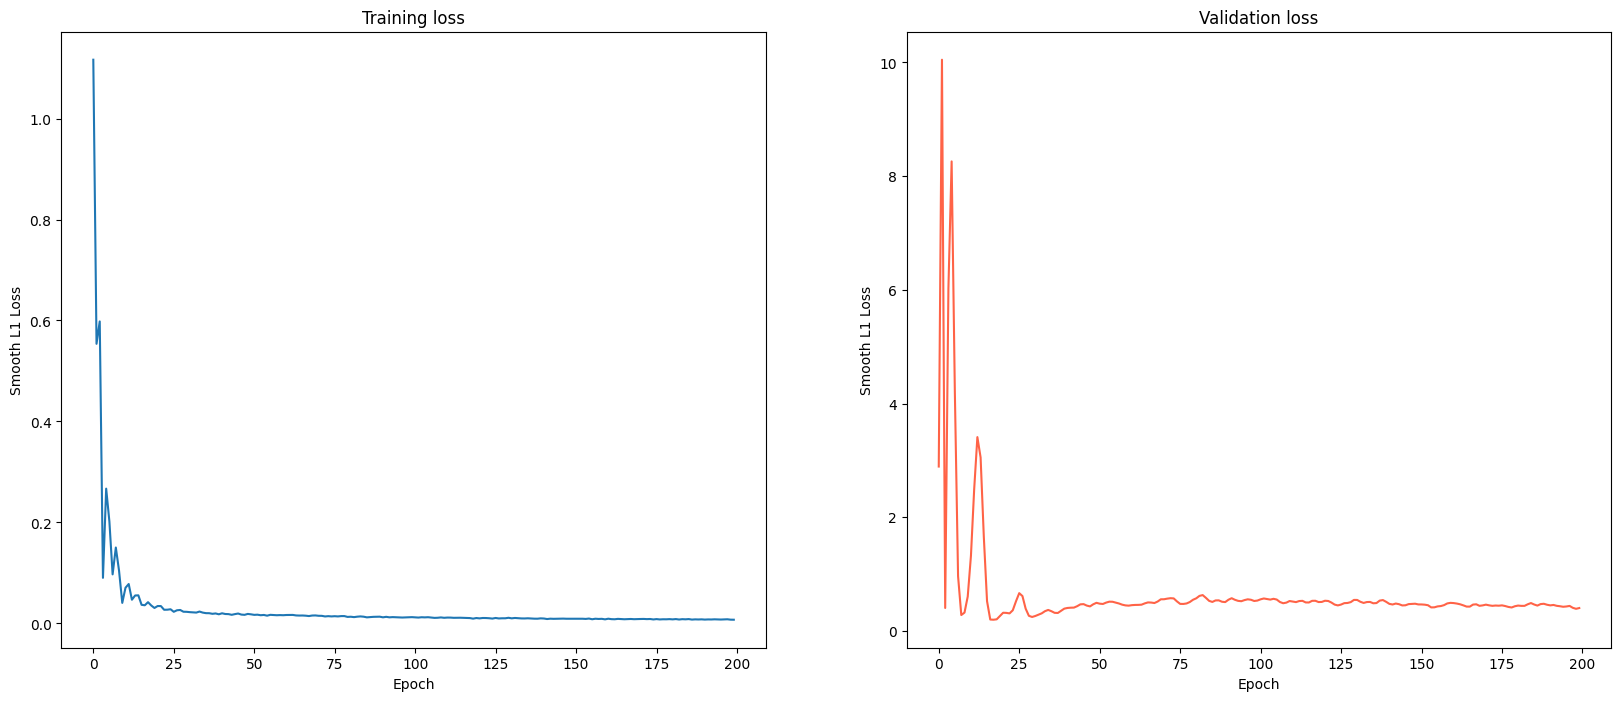

In [ ]:
optimizer.param_groups[0]['lr']=0.0001

epoch_plot=[]
val_plot=[]
num_epochs=200
counter=0
teacher_forcing_rate=1.
for epoch in range(0, num_epochs):

    # Call train and validate 
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))
    
    curr_lr = float(optimizer.param_groups[0]['lr'])
    
    train_loss              = trainer.train(teacher_forcing_rate=teacher_forcing_rate)
    epoch_plot.append(train_loss)

    val_loss              = trainer.validate()

    val_plot.append(val_loss)

    teacher_forcing_rate=max(teacher_forcing_rate-0.05, 0.5)
    if teacher_forcing_rate<0.5:
      teacher_forcing_rate=0.9

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))

fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(epoch_plot)
ax[0].set_ylabel("Smooth L1 Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_plot, color='tomato')
ax[1].set_ylabel("Smooth L1 Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path="/content/drive/MyDrive/stockprices/checkpoint_APPL.pth"
torch.save({'model_state_dict':trainer.model.state_dict(),
                  'optimizer_state_dict':trainer.optimizer.state_dict(),
                  'epoch': epoch}, path)

In [ ]:
# path="/content/drive/MyDrive/stockprices/checkpoint_GOOGL.pth"
# checkpoint = torch.load(path)
# model.load_state_dict(checkpoint['model_state_dict'])
# trainer.model=model

# Testing

In [ ]:
#window size: 65, context_len:5, pred_len: 5 
prediction=trainer.test(test_loader)
prediction=[i.cpu().detach().item() for i in prediction]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
print(len(prediction))
print(np.array(dataset)[:,3].shape[0])


1220
1258


In [ ]:
prediction_padded=np.pad(prediction,(context_len+1, pred_len),'constant', constant_values=(prediction[0], prediction[-1]))
print(r2_score(np.array(dataset)[:,3], prediction_padded))

0.9749658805173815


In [ ]:
prediction_padded.shape

(1258,)

In [ ]:
actual_data=Scaler.inverse_transform(dataset_standard)
print(actual_data)

[[ 4.41225010e+01  4.47350010e+01  4.41025010e+01 ... -1.00002000e-01
   0.00000000e+00  4.19557502e+01]
 [ 4.44524990e+01  4.47050020e+01  4.42200010e+01 ... -1.00002000e-01
   0.00000000e+00  4.19557502e+01]
 [ 4.34399990e+01  4.38475000e+01  4.31650010e+01 ... -1.25999800e+00
   0.00000000e+00  4.19557502e+01]
 ...
 [ 1.61220001e+02  1.62059998e+02  1.59779999e+02 ... -6.99997000e-01
   0.00000000e+00  1.63118001e+02]
 [ 1.61630005e+02  1.65800003e+02  1.61419998e+02 ...  5.45999200e+00
   1.00000000e+00  1.63597000e+02]
 [ 1.64589996e+02  1.66320007e+02  1.63820007e+02 ... -3.49991000e-01
   0.00000000e+00  1.63882001e+02]]


In [ ]:
dataset_standard_copy=dataset_standard.copy()
dataset_standard_copy[:,3]=prediction_padded
predict_data=Scaler.inverse_transform(dataset_standard_copy)

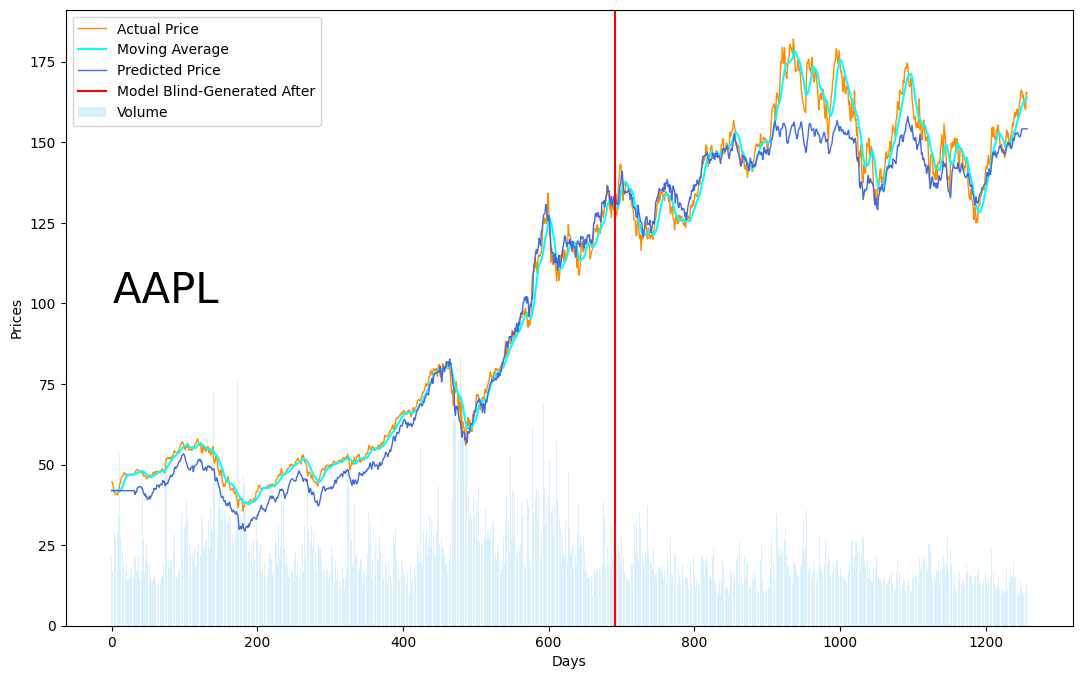

In [ ]:
plt.figure(figsize=(13,8))
plt.plot(np.array(actual_data)[:,3], label='Actual Price', color='darkorange', linewidth=1)
plt.plot(np.array(actual_data)[:,7], label='Moving Average', color='cyan')
plt.bar(x=np.arange(0,len(dataset)), height=np.array(actual_data)[:,4]/5000000 , label='Volume', color='lightskyblue', alpha=0.3)

plt.plot( predict_data[:,3], label='Predicted Price',color='royalblue', linewidth=1)
plt.axvline(x = int(len(dataset)*0.55), color='r', label="Model Blind-Generated After")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Prices")
plt.annotate("AAPL",xy=(0.3,70),textcoords='offset points', fontsize=30)
plt.savefig("AAPL1.png", transparent = False)

In [ ]:
plt.savefig("AAPL1.png", transparent = False)

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd

In [ ]:
dff=pd.DataFrame(predict_data[:,3], columns=['Pred_Close'])
dff.to_csv("AAPL_pred.csv")
dff

,Pred_Close
0,41.905858
1,41.905858
2,41.905858
3,41.905858
4,41.905858
...,...
1253,154.144262
1254,154.144262
1255,154.144262
1256,154.144262


In [ ]:
# #window size: 65, context_len:5, pred_len: 5 
# pp=[]
# pbar = tqdm(total=800,desc="predicting...")
# for i in range(800):
#   query=dataset[context_len-1+i:window_size-1+i]
#   tar=torch.FloatTensor(query).unsqueeze(0).to(device)   #1,5, 9
#   src=torch.FloatTensor(dataset[0+i: context_len+i]).unsqueeze(0).to(device)   #1, 65,9

#   out=trainer.model(src,tar) 
#   o=out.cpu().detach().numpy()[0,1]  
#   pp.append(o)
#   pbar.update()
# pbar.close()
# pp=np.squeeze(pp)
# pp.shape

In [ ]:
# #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
# plt.figure(figsize=(10,8))
# plt.plot(np.array(dataset)[:1100,4], label='Actual Price', color='darkorange', linewidth=1)
# plt.plot(np.array(dataset)[:1100,8], label='Moving Average', color='cyan')
# plt.bar(x=np.arange(0,1100), height=np.array(dataset)[:1100,5]/5, label='Volume', color='lightskyblue', alpha=0.3)
# plt.annotate("GOOGL",xy=(0.3,0.6),textcoords='offset points')
# plt.plot(np.arange(context_len,800+context_len), pp, label='Predicted Price',color='royalblue', linewidth=0.5)
# plt.legend()
# # plt.ylim(200,400)

In [ ]:
# import seaborn as sns

In [ ]:
# def test_for_agent( model, test_loader):
#       model.eval() # set to training mode
#       model.to(device)
#       batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
#       prediction=[]
#       for i, batch in enumerate(test_loader):
#           # self.optimizer.zero_grad()

#           src, trg, y_test = batch

#           src = src.to(device)
#           trg = trg.to(device)

#           batch_size = src.shape[0]

#           y_pred = model(src, trg, src_mask=None, tgt_mask=None)
#           prediction.append(y_pred[0])

#           #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
#           del src, trg, y_test
#           torch.cuda.empty_cache()
#           batch_bar.update()

#       batch_bar.close()

#       return prediction

In [ ]:
# prediction=test_for_agent(model=trainer.model, test_loader=test_loader)
# prediction=[i.cpu().detach().numpy() for i in prediction]
# prediction

[array([[-1.316052 ],
        [-1.3142991],
        [-1.314555 ],
        [-1.3158753],
        [-1.3132709],
        [-1.3166245],
        [-1.3156633],
        [-1.3159788],
        [-1.3156546],
        [-1.3145263]], dtype=float32),
 array([[-1.331852 ],
        [-1.3320996],
        [-1.3338634],
        [-1.3307288],
        [-1.3346012],
        [-1.3334862],
        [-1.3339349],
        [-1.3333862],
        [-1.3320678],
        [-1.3349305]], dtype=float32),
 array([[-1.3192785],
        [-1.320976 ],
        [-1.3179997],
        [-1.3217473],
        [-1.3206264],
        [-1.3210665],
        [-1.3205423],
        [-1.3192427],
        [-1.32206  ],
        [-1.3212943]], dtype=float32),
 array([[-1.3006816],
        [-1.2980576],
        [-1.301499 ],
        [-1.3005596],
        [-1.3007632],
        [-1.3004829],
        [-1.2992946],
        [-1.3019378],
        [-1.3010293],
        [-1.3028376]], dtype=float32),
 array([[-1.2928857],
        [-1.2960539],
        

In [ ]:
# prediction=np.squeeze(np.array(prediction))
# prediction.shape

(1217, 10)

In [ ]:
# prediction=prediction[int(0.5*len(dataset)):]


In [ ]:
# pred_data=Scaler.inverse_transform(prediction)
# plt.plot(pred_data[:,0])

# Experiment

In [ ]:
# Login to Wandb
# Initialize your Wandb Run Here
# Save your model architecture in a txt file, and save the file to Wandb

In [ ]:
# Optional: Load your best model Checkpoint here

# TODO: Create a testing function similar to validation 
# TODO: Create a file with all predictions 
# TODO: Submit to Kaggle